# Train BERT Model for extracting person and company names </br>
- This notebook generates training data and finetunes BERT model using huggingface library

- Modeled as multi-label classification problem (3 classes being - person, org, none)


### Documents:

- Complete Results: https://docs.google.com/spreadsheets/d/1rzEQrqRDqQpZ95_G95Fl1MKQppWJ1lAPBuOU6LVNiXY/edit?usp=sharing

- Slides: https://docs.google.com/presentation/d/1EdubLHYdHDPJKT1GYHjkP86ZJMqjEhM_PFhvmWXCHSg/edit?usp=sharing

- Final Intern presentation: https://docs.google.com/presentation/d/10mXA7K5sa_nAkqx2onsIfrH3TPj2Ni4LfCOxDhN5XBI/edit?usp=sharing

In [1]:
import os
import importlib
import logging
importlib.reload(logging)
import framework
importlib.reload(framework)
import bert_ner
importlib.reload(bert_ner)
import infer_bert_classifier
importlib.reload(infer_bert_classifier)
import bert_utils
importlib.reload(bert_utils)
import pandas as pd
from framework import DataCuration, FeatureEngineering
from bert_ner import TaskNER, FeatureEngineeringNER, BERTNER

# Define some constants and configurations
logging.getLogger().setLevel(logging.INFO)
ACCESS_TOKEN = 'WUpGevbWC9lsnTW8quNUtmWRdAEM89'

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahsaasbajaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ahsaasbajaj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Specify Task
- Mention configurations of the task and create a task object

In [2]:
DATASET = 'w2' # supports w2 and resume

# also supports 'address' as 4th category in task
TASK_CONFIG = {
    'task': 'ner',
    'num_labels': 3,
    'labels_dict': {'person' : 0, 'org' : 1, 'none': 2}
}

task = TaskNER(TASK_CONFIG)

## Curate dataset
- Specify paths for dataset and goldens (if available). Paths can be local or from instabase drives (use *is_local*). 
- Also specify configurations like extensions, column names to use as index. 
- Currently supports csv format for goldens, ibocr/ibdoc for dataset. 
- Use *context2txt* to extract and store raw texts. 
- This block creates a object of DataCuration() which maps goldens with the dataset and removes any mismatches, generates 1:1 mapping. 
- This object can be queried using *data.golden* or *data.dataset* or *data.dataset.texts* based on requirement

### Files:
- Download documents (ibocr or ibdoc files) after running flow on raw files here https://www.kaggle.com/mcvishnu1/fake-w2-us-tax-form-dataset/. Use s2_map_records. 
- Flow outputs and processed goldens here: https://drive.google.com/drive/folders/1ahbOaUUPXK7qvyotxMParTx4rjdLv0bA?usp=sharing. Download and specify local directory path in code below and set *is_local* = True
- Alternatively, specify instabase drive paths and set *is_local* as False

In [3]:
# Path to publicly available W2 forms (Kaggle)
W2_DATA = [
   '/Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/ocr/out-pdf'
]
W2_GOLDEN = [
   '/Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/golden/goldens.csv'
]

GOLDEN_CONFIG = {
    'path': W2_GOLDEN,
    'is_local': True,
    'index_field_name':'File_BaseName',
    'file_type': 'csv',
    'identifier': 'file'
}
DATASET_CONFIG = {
    'path': W2_DATA,
    'is_local': True, 
    'file_type': 'ibocr',
    'identifier': lambda path: os.path.basename(path).split('.ibocr')[0].split('.pdf')[0],
    'convert2txt': True
}

data = DataCuration(ACCESS_TOKEN, DATASET_CONFIG, GOLDEN_CONFIG)

INFO:root:Loading dataset from /Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/ocr/out-pdf
INFO:root:1994 files loaded
INFO:root:Loading goldens from /Users/ahsaasbajaj/Documents/Data/W2/W2_Clean_DataSet_01_20Sep2019/golden/goldens.csv
INFO:root:Total files Goldens: (2000, 45)
INFO:root:Total files found in the source with unique index: (1994, 45)
INFO:root:Processing 1994 IBOCR files to txt


In [4]:
assert(len(data.dataset.keys()) == data.golden.shape[0])

### Split inputs document to generate *candidate phrases*
- These are subsequent tokens clustered using whitespacing information
- These are used as strings (to train/test) sequence classifiers
- Golden person, org names have to be one of these phrases in order to be extracted by this solution

In [5]:
PROCESSING_CONFIG = {
    'X_DIST_THRESHOLD': 200,
    'RANDOM_SEQ_LEN': 5
}

# use as negative filter to generate random sequences
employer_address = ['Employer\'s Street Address', 'Employer\'s City-State-Zip']
employee_address = ['Employee Street Address', 'Employee\'s City-State-Zip']
other_location = ['Locality Name_1', 'State_1', 'Locality Name_2', 'State_2']

DATA_ARGS = {
    'task': task,
    'dataset': data,
    'candidates_fields': {
        'org':'Employer\'s Name',
        'person':'Employee Name',
        'address1': employer_address,
        'address2': employee_address,
        'address3': other_location
    },
    'use_random_seq': True, # if False, then use phrases generated by generate_candidates_phrases() for 'None' class in classifier training data
    'mode': 'person-org' # person-org or person-org-address, need to change label_dict in Task accordingly
}

data.generate_candidates_phrases(PROCESSING_CONFIG)
data.compare_candidates_and_goldens(DATA_ARGS['candidates_fields'])

INFO:root:Generating candidates for 1994 files
INFO:root:For X_DIST_THRESHOLD configuraion: 200
INFO:root:total files: 1994
person names found in candidates: 1987
org names found in candidates: 1992



### Train-Test Split (supports dictionary as well as dataframe)

In [6]:
data.split_train_test()

INFO:root:Total samples 1994, training samples: 1327, Test Samples: 667


## Feature Engineering (Generate Labeled Data)
- Specify DATA_ARGS which includes the task and data objects created beforehand
- Mention fields of interest (for extraction, classification) in DATA_ARGS
- Generate training data using golden person, company names and picking random sequences (for third class a.k.a none) from *candidate phrases* produced by *data.generate_candidates_phrases()*

In [7]:
fe = FeatureEngineeringNER(DATA_ARGS)
train_data, test_data = fe.create_train_test_data(PROCESSING_CONFIG)
train_data.head(20)

INFO:root:Generating labeled data for dataset with shape (1327, 45)
INFO:root:Cleaned text size 1327
INFO:root:Random Sequence text size 1327
INFO:root:Mode person-org
INFO:root:Generating labeled data for dataset with shape (667, 45)
INFO:root:Cleaned text size 667
INFO:root:Random Sequence text size 667
INFO:root:Mode person-org
INFO:root:train data: (3981, 2), test test: (2001, 2)


context  label
641                                Zachary Reynolds      0
527                              f address ZIP code      2
1135                                  Park-Cruz PLC      1
672                                  Webb-Davis PLC      1
1154                          Miles-Howard and Sons      1
269                                Hudson Ltd Group      1
1172                              Daugherty Ltd Ltd      1
407   b Employer identification number compensation      2
379                  Hayes, Carter and Dennis Group      1
722                                  Brian Alvarado      0
687                           Other enclosed Notice      2
172                                    Heather Hill      0
373                                   Edward Miller      0
535                   Howell, Gill and Bailey Group      1
152                                 Michael Randall      0
1320             Morrow, Black and Fleming and Sons      1
1229                    Campos, Jones and Sharp PLC      1
343                                  Deborah Warren      0
187                                      Lisa Myers      0
255          Christensen, Downs and Blackwell Group      1

### Optionally, Generate training dataset from public names (of persons and companies) </br>
This only supports 'person-org' and has no addresses. This uses candidates generated by generate_candidates_phrases()
Download files from https://drive.google.com/drive/folders/1ooQtdWwciJtDVjlriHSwmeFILcsZlaTq?usp=sharing and give paths to local files in code below

In [8]:
DATA_ARGS_PUBLIC = {
    'task': task,
    'filepaths': {
        'org':'/Users/ahsaasbajaj/Documents/Data/names/companies_sorted.csv',
        'person1':'/Users/ahsaasbajaj/Documents/Data/names/first_names.all.txt',
        'person2': '/Users/ahsaasbajaj/Documents/Data/names/last_names.all.txt',
        'none': '/Users/ahsaasbajaj/Documents/Data/names/none_phrases200.csv' # generated from datacuration.candidates with person, org, address filtered out as in FeatureEngineeringNER().create_train_test_data
    },
    'name_field': {
        'person': 'name', # field name inside text files or csv
        'org': 'name',
        'none': 'context'
    },

    'mode': 'person-org' # person-org or person-org-address, need to change label_dict in Task accordingly
}

In [9]:
train_data_public, test_data_public = FeatureEngineeringNER.create_train_test_data_from_files(DATA_ARGS_PUBLIC)
train_data_public.head(10)

INFO:root:Total 7173426 company names available
INFO:root:Total 164432 first names, 98391 last names available
INFO:root:Total 44738 none phrases available
INFO:root:Selecting minimum of three categories available, min count: 44738
INFO:root:Total samples 134213, training samples: 94072, Test Samples: 40141


context  label
40924                            shobhna mccamey      0
122373                     social security wages      2
84180                  liberty safes of san jose      1
53113                               partners gin      1
7112                       oluwadamilare hargest      0
119976               22705 wise squares apt. 168      2
76264                 hyperionit private limited      1
19241                              ryland ewbank      0
60017                             the earth home      1
90399   c employer's name, address, and zip code      2

In [10]:
# For Debugging
train_data = FeatureEngineering.get_subset_for_debugging(train_data, sample_size=20)
test_data = FeatureEngineering.get_subset_for_debugging(test_data, sample_size=10)

## Modeling (BERT Finetuning for sequence classification)
- Specify model type (architecture)
- This model uses pretrained BERT Language model and finetuned to perform multi-label classification (person, org, none). Here, we solve extraction using classification approach
- Publicly available datasets (Kaggle W2 or public lists of names) are used for training (as generated above)

### Specify TRAINING_ARGS
- Mention the class of model, to be used appropriately by back-end huggingface libraries
- Mention the number of labels (in case of multi-label classification)
- Also supports the use of GPU for deep learning libraries
- Mention training, dev, test data splits
- Specify training hyperparameters like epochs, batch_size

### This block performs the following
- Trains model and wites it in *outputDir* path
- Print loss and accuracy plots
- Print evaluation metrics (Recall, Precision, F1 score) on different data splits

INFO:root:Finetuning BERT Model
INFO:root:outDir: ../models/bert_classifier, trainFile: (20, 2), devFile: (10, 2), testFile: (10, 2)
INFO:root:Device cpu, GPU False, epochs: 4, batch_size: 32
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]INFO:root:Training for 1 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.1966
INFO:root:Training Accuracy: 0.2000
INFO:root:Validation Accuracy: 0.2000
Epoch:  25%|██▌       | 1/4 [00:45<02:15, 45.02s/it]INFO:root:Training for 2 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.2542
INFO:root:Training Accuracy: 0.3000
INFO:root:Validation Accuracy: 0.2000
Epoch:  50%|█████     | 2/4 [01:34<01:32, 46.37s/it]INFO:root:Training for 3 epoch
INFO:root:Training for 1 step
INFO:root:Total tr steps: 1, total tr examples: 20
INFO:root:Train loss: 1.1050
INFO:root:Training Accuracy: 0.4000
INFO:root:Validation Accuracy: 0.2000
Epoch:  75%|███

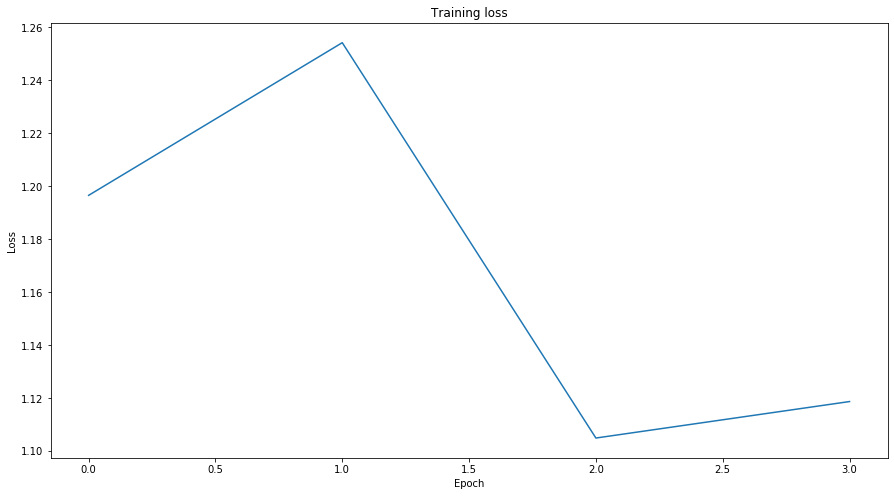

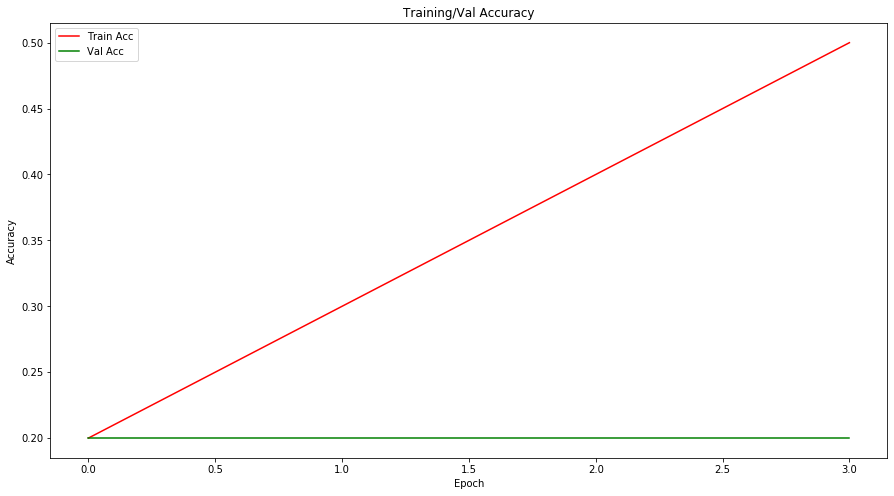

In [11]:
TRAINING_ARGS = {
    'outputDir': '../models/bert_classifier',
    'trainFile': train_data,
    'devFile': test_data,
    'testFile': test_data,
    'gpu': False,
    'model_name_or_path': 'bert-large-cased',
    'num_labels': TASK_CONFIG['num_labels'],
    'epochs': 4,
    'batch_size': 32
}

model = BERTNER(DATA_ARGS, TRAINING_ARGS)
model.train()

### Trained Models (on complete datasets):
- Using Kaggle W2 : https://drive.google.com/drive/folders/1IK5ydGZOaeUmHqJ6eKfogO1zTHCfykQJ?usp=sharing
- Using public repo of names: https://drive.google.com/drive/folders/1ZEJlu95Kzc86FO9ZsVCkCRnwQ51tg4vH?usp=sharing
